In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import ttest_ind

In [10]:
data = pd.read_csv("figure9_mean.csv")

In [11]:
data

,Subset Ratio,Model,Overall score
0,10%,MINERVA [0-0.1],0.8224
1,10%,MINERVA [0-0.1],0.8251
2,10%,MINERVA [0-0.1],0.8205
3,10%,MINERVA [0-0.1],0.8219
4,10%,MINERVA [0-0.1],0.8240
...,...,...,...
115,100%,Baseline,0.8472
116,100%,Baseline,0.8438
117,100%,Baseline,0.8457
118,100%,Baseline,0.8459


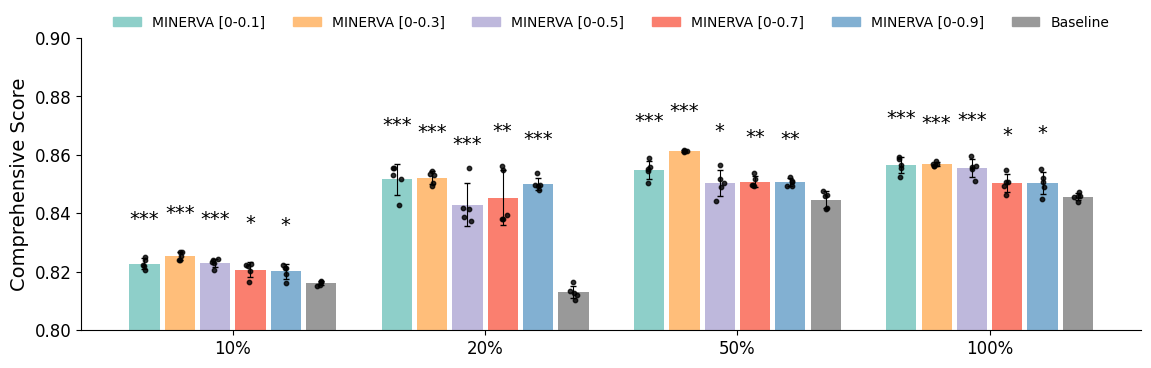

In [15]:
model_order = ['MINERVA [0-0.1]', 'MINERVA [0-0.3]', 'MINERVA [0-0.5]', 'MINERVA [0-0.7]', 'MINERVA [0-0.9]', 'Baseline']
colors = ['#8ECFC9', '#FFBE7A', '#BEB8DC', '#FA7F6F', '#82B0D2', '#999999'] 
model_colors = {model: colors[i] for i, model in enumerate(model_order)}

display_labels = ['10%', '20%', '50%', '100%'] 
data_selection_labels = ['10%', '20%', '50%', '100%']


grouped_data = data.groupby(['Subset Ratio', 'Model'])['Overall score'].agg(['mean', 'std']).reset_index()


fig, ax = plt.subplots(figsize=(12, 4))
num_models = len(model_order)
bar_width = 0.12
intra_group_gap = 0.02
step_width = bar_width + intra_group_gap
x = np.arange(len(display_labels))

bar_info = {}

for i, model in enumerate(model_order):
    offset = (i - (num_models - 1) / 2) * step_width
    positions = x + offset
    bar_info[model] = {'positions': positions}
    
    model_means = grouped_data[grouped_data['Model'] == model].set_index('Subset Ratio').loc[data_selection_labels]['mean']
    model_stds = grouped_data[grouped_data['Model'] == model].set_index('Subset Ratio').loc[data_selection_labels]['std']
    bar_info[model]['means'] = model_means
    bar_info[model]['stds'] = model_stds

    ax.bar(positions, model_means, width=bar_width, color=model_colors[model])
    ax.errorbar(positions, model_means, yerr=model_stds, fmt='none', ecolor='black', capsize=2, elinewidth=0.8)

    for j, subset in enumerate(data_selection_labels):
        raw_scores = data[(data['Model'] == model) & (data['Subset Ratio'] == subset)]['Overall score']
        jittered_x = np.random.normal(positions[j], 0.008, size=len(raw_scores))
        ax.scatter(jittered_x, raw_scores, color='black', s=10, alpha=0.8, zorder=2)


def get_significance_symbol(p_value):
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return 'ns'

baseline_scores_map = {subset: data[(data['Model'] == 'Baseline') & (data['Subset Ratio'] == subset)]['Overall score'] for subset in data_selection_labels}

for i, model in enumerate(model_order):
    if model == 'Baseline': continue
    
    for j, subset in enumerate(data_selection_labels):
        model_scores = data[(data['Model'] == model) & (data['Subset Ratio'] == subset)]['Overall score']
        _, p_value = ttest_ind(model_scores, baseline_scores_map[subset], equal_var=False)
        symbol = get_significance_symbol(p_value)
        
        if symbol != 'ns':
            pos_x = bar_info[model]['positions'][j]
            pos_y = bar_info[model]['means'][j] + bar_info[model]['stds'][j] + 0.01
            ax.text(pos_x, pos_y, symbol, ha='center', va='bottom', fontsize=14, color='black')

ax.set_ylim(bottom=0.8, top=0.9)
ax.set_ylabel("Comprehensive Score", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(display_labels, size=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', direction='out', labelsize=12)

handles = [plt.Rectangle((0,0),1,1, color=model_colors[model]) for model in model_order]
ax.legend(handles, model_order, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=6, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figure9_mean.svg',dpi = 300, bbox_inches = 'tight')
plt.show()